# Model inference using geometry only B-GUN

In [12]:
import torch
import numpy as np
import pandas as pd
import sys
sys.path.append('../')
from src.core import gun_arch_binaryPool_edgeconv

from src.utils import visualisation_parameters
import matplotlib.pyplot as plt

import ast
import copy

In [13]:
def load_model(HYPER_PARAMS, MODEL_PARAMS, TRAINED_MODEL_PATH, MODEL_NAME):
    """
    Loads the GBF-GUN model
    """
    # Unpack hyperparameters
    H_VALUE = HYPER_PARAMS['H_VALUE']  # Dimension of the feature embeddings
    DEPTH = HYPER_PARAMS['DEPTH']  # Number of coarsening levels
    W_VALUE = HYPER_PARAMS['W_VALUE']  # Width of the edge convolution MLP
    L_VALUE = HYPER_PARAMS['L_VALUE']  # Number of layers in the edge convolution MLP
    WEIGHT_DECAY = HYPER_PARAMS['WEIGHT_DECAY']  # Weight decay for the optimizer; to deal with noisy predictions
    LEARNING_RATE = HYPER_PARAMS['LEARNING_RATE']  # Learning rate for the optimizer
    
    # Unpack model parameters
    IN_CHANNELS = MODEL_PARAMS['IN_CHANNELS']  # Number of input features at each node
    OUT_CHANNELS = MODEL_PARAMS['OUT_CHANNELS']  # Number of output features at each node
    
    # Initialize the model
    gun_model_viscous = gun_arch_binaryPool_edgeconv.LightningGraphUNetEdgeConv(in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS, hidden_channels=H_VALUE, depth=DEPTH, v_cycles=1, ec_mlp_width=W_VALUE, ec_mlp_layer=L_VALUE, weight_decay=WEIGHT_DECAY, lr=LEARNING_RATE)

    checkpoint = torch.load(TRAINED_MODEL_PATH + MODEL_NAME, map_location=torch.device('cpu'))
    gun_model_viscous.load_state_dict(checkpoint["state_dict"])

    # disable randomness, dropout, etc...
    gun_model_viscous.eval()

    return gun_model_viscous

def load_dataset_stats(TRAINED_MODEL_PATH):
    """
    Loads test data set and training data stats
    """

    dataset_info_path = f"{TRAINED_MODEL_PATH}split_dataset_info_seed_888/"
    minmax_stats_path = dataset_info_path + "minmax_normalization_stats.csv"
    minmax_df = pd.read_csv(minmax_stats_path)
    PYG_GRAPH_PATH_TEST_GBF = "../data/airfrans_test_data_GBF.pt"
    pyg_graph_dict_test = torch.load(PYG_GRAPH_PATH_TEST_GBF)

    return minmax_df, pyg_graph_dict_test

def rotate_airfoil_coordinates(airfoil_coordinates, angle_of_attack):
    angle_of_attack = angle_of_attack * (np.pi/180)
    rotated_airfoil_coordinates = np.zeros((airfoil_coordinates.shape[0], airfoil_coordinates.shape[1]))
    rotated_airfoil_coordinates[:,0] = airfoil_coordinates[:,0] * np.cos(angle_of_attack) + airfoil_coordinates[:,1] * np.sin(angle_of_attack)
    rotated_airfoil_coordinates[:,1] = - airfoil_coordinates[:,0] * np.sin(angle_of_attack) + airfoil_coordinates[:,1] * np.cos(angle_of_attack)
    return rotated_airfoil_coordinates

def minmax_normalize_sample(minmax_df, sample_graph_dict):
    """
    Normalizes the sample graph using the provided normalization statistics.

    Args:
        norm_stats (list): List containing the normalization statistics.
        sample_graph_dict (dict): Dictionary containing the sample graph data.

    Returns:
        sample_graph_dict (dict): Dictionary containing the normalized sample graph data
    """
    
    # Unpack the normalization statistics
    # Convert string to list
    # min_x = np.array(ast.literal_eval(minmax_df['min_x[pos_x,pos_y,re/cp_inv]'].values[0]))
    min_x = torch.tensor(ast.literal_eval(minmax_df['min_x[pos_x,pos_y,re]'].values[0]))
    max_x = torch.tensor(ast.literal_eval(minmax_df['max_x[pos_x,pos_y,re]'].values[0]))
    min_y = torch.tensor(ast.literal_eval(minmax_df['min_y[cp]'].values[0]))
    max_y = torch.tensor(ast.literal_eval(minmax_df['max_y[cp]'].values[0]))
    
    # Make copies of the dictionaries
    sample_graph_dict_copy = copy.deepcopy(sample_graph_dict)
    
    # Normalize feature vector (Data.x)
    sample_graph_dict_copy.x = (sample_graph_dict_copy.x - min_x) / (max_x - min_x)
    sample_graph_dict_copy.x = sample_graph_dict_copy.x.float()
    sample_graph_dict_copy.y = (sample_graph_dict_copy.y - min_y) / (max_y - min_y)
    sample_graph_dict_copy.y = sample_graph_dict_copy.y.float()
    
    return sample_graph_dict_copy, min_x.float().numpy(), max_x.float().numpy(), min_y.float().numpy(), max_y.float().numpy()

In [14]:
# The model hyperparameters
H_VALUE = 8 # Dimension of the feature embeddings
DEPTH = 6 # Number of coarsening levels
W_VALUE = 128 # Width of the edge convolution MLP
L_VALUE = 2 # Number of layers in the edge convolution MLP
WEIGHT_DECAY = 0.0 # Weight decay for the optimizer; to deal with noisy predictions
LEARNING_RATE = 1e-4 # Learning rate for the optimizer

HYPER_PARAMS = {
    "H_VALUE": H_VALUE,
    "DEPTH": DEPTH,
    "W_VALUE": W_VALUE,
    "L_VALUE": L_VALUE,
    "WEIGHT_DECAY": WEIGHT_DECAY,
    "LEARNING_RATE": LEARNING_RATE
}

# Model parameters
IN_CHANNELS = 3 # Number of input features at each node
OUT_CHANNELS = 1 # Number of output features at each node

MODEL_PARAMS = {
    "IN_CHANNELS": IN_CHANNELS,
    "OUT_CHANNELS": OUT_CHANNELS
}

# Path to model
MODEL_NAME = "gbf_bgun_epoch=13449-train_loss=6.33939e-06-val_loss=4.73487e-05.ckpt"
TRAINED_MODEL_PATH = "../models/trained_models/GBF-B-GUN/"

# Load the model
gun_model_viscous = load_model(HYPER_PARAMS, MODEL_PARAMS, TRAINED_MODEL_PATH, MODEL_NAME)

/var/folders/gv/0wtlt8px0t36v_dx5c5q4r4xzc3l_g/T/ipykernel_39609/924340382.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(TRAINED_MODEL_PATH + 

/var/folders/gv/0wtlt8px0t36v_dx5c5q4r4xzc3l_g/T/ipykernel_39609/924340382.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pyg_graph_dict_test = torch.load(PYG_GRAPH_PA

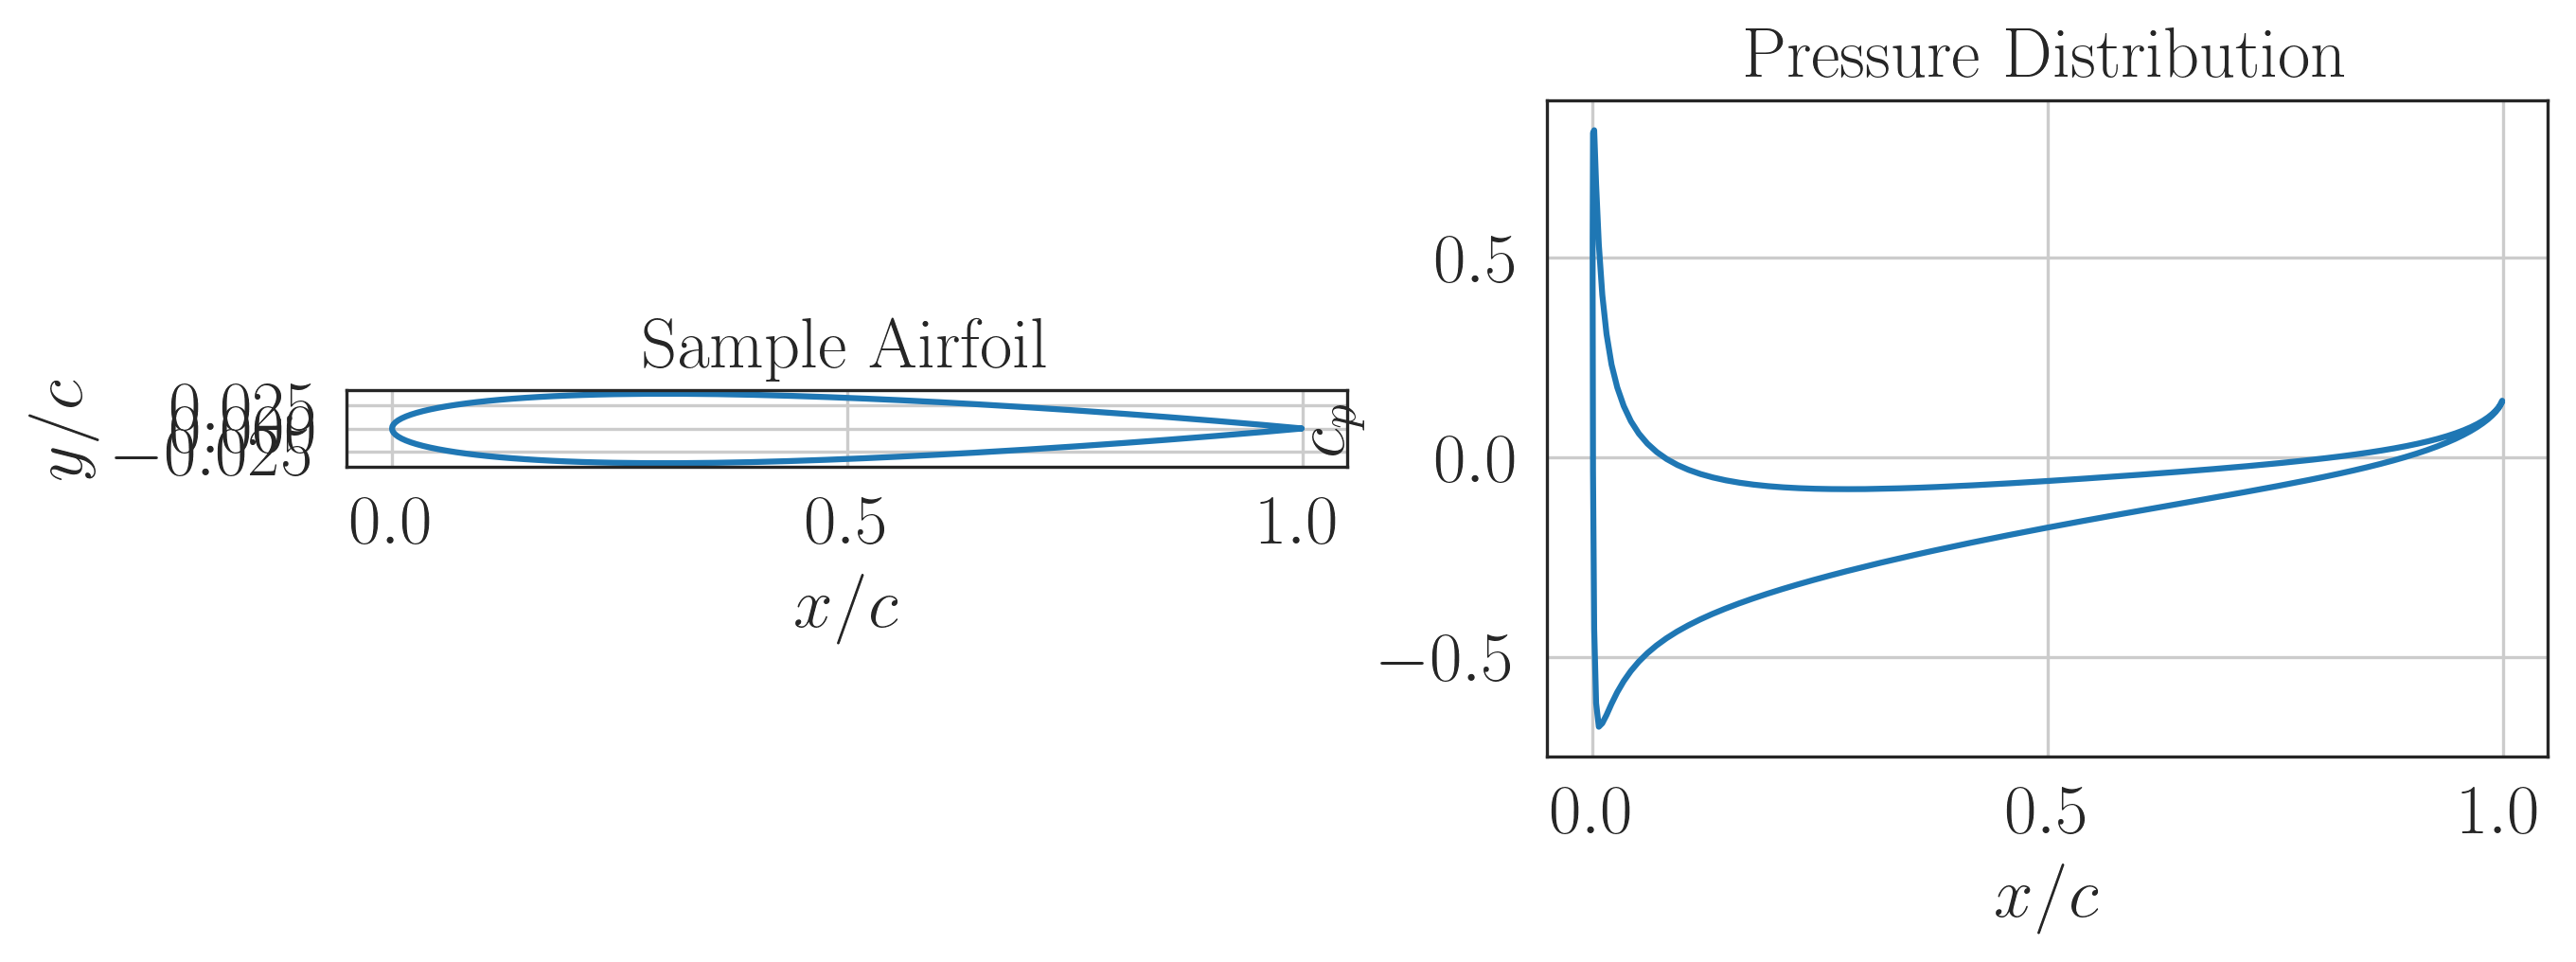

In [15]:
minmax_df, test_data = load_dataset_stats(TRAINED_MODEL_PATH)
test_keys = list(test_data.keys())
# Sample test data
# key_ = ('31.812', '1.334', '0.371_3.287_0.0_19.548')
key_idx = 99  # Change this index to select different test samples
key_ = test_keys[key_idx]
U_infty = float(key_[0])
aoa = float(key_[1])
airfoil_graph = test_data[key_]
rotated_airfoil_coordinates = airfoil_graph.x[:,0:2].numpy()
airfoil_coordinates = rotate_airfoil_coordinates(rotated_airfoil_coordinates, -aoa)
re_ = airfoil_graph.x[:,2].numpy()

# Plot the airfoil
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axs[0].plot(airfoil_coordinates[:, 0], airfoil_coordinates[:, 1])
axs[0].set_title("Sample Airfoil")
axs[0].set_xlabel(r"$x/c$")
axs[0].set_ylabel(r"$y/c$")
axs[0].grid(True)
axs[0].set_aspect('equal')

# Plot the pressure distribution
pressure_distribution = airfoil_graph.y.numpy()
axs[1].plot(airfoil_coordinates[:, 0], pressure_distribution)
axs[1].set_title("Pressure Distribution")
axs[1].set_xlabel(r"$x/c$")
axs[1].set_ylabel(r"$c_p$")
axs[1].grid(True)

### Inference using model

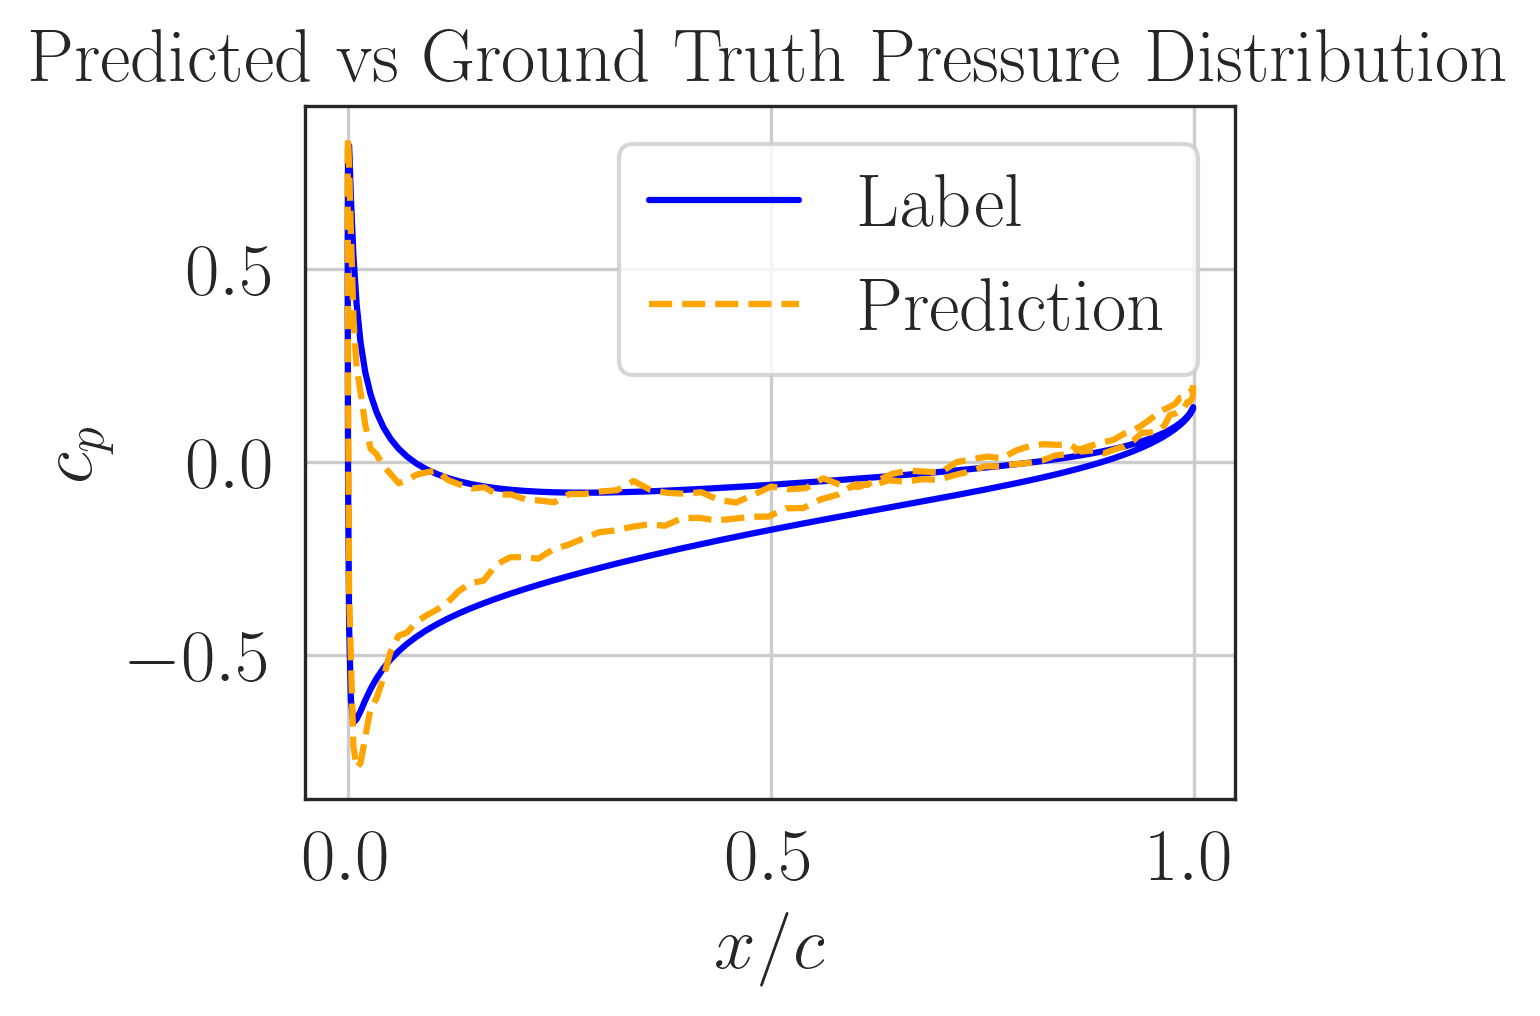

In [19]:
test_graph_sample = test_data[key_]
test_graph_sample_norm, min_x, max_x, min_y, max_y = minmax_normalize_sample(minmax_df, test_graph_sample)

# Data
label_real = test_graph_sample.y[:, 0].numpy().flatten()

# Predict using the model
out_ = gun_model_viscous.predict_step(test_graph_sample_norm, batch_idx=530)
pred_real = (out_.detach().numpy().flatten() * (max_y - min_y)) + min_y

# Plot the pressure distribution
plt.figure(figsize=(4,3))
plt.plot(airfoil_coordinates[:, 0], label_real, label='Label', linestyle='-', color='blue')
plt.plot(airfoil_coordinates[:, 0], pred_real, label='Prediction', linestyle='--', color='orange')
plt.title("Predicted vs Ground Truth Pressure Distribution")
plt.legend()
plt.xlabel(r"$x/c$")
plt.ylabel(r"$c_p$")
plt.grid(True)